In [2]:
%matplotlib inline

import sys
import datetime
import random
import math

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import Quandl
import numpy as np
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.grid_search import GridSearchCV

from utils import utils as ut
from utils import quandl as ql
from utils import composite
from utils import maps
from settings import TARGET_SERIES, TARGET_INDICATOR

sns.set_style("dark")

/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [47]:
tar = ql.load_target()
tar = ut.xs_z_score_winsorize(tar)
tar = tar[datetime.date(1999,1,1):]
PANEL_SCORE = True

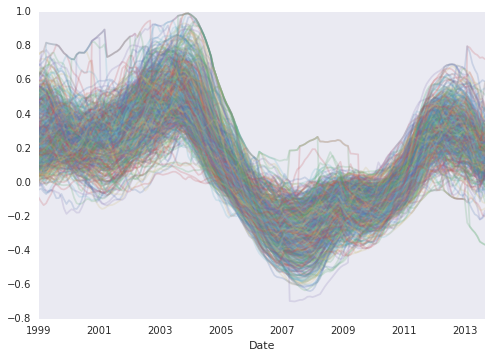

In [48]:
tar.plot(legend=False, alpha=.2)

## increasing values

In [27]:
series = 'IV'
px, px_ca, px_us = ql.load_series(series)
print(px.shape, px.dropna().shape)
#composite.explore_series(px, px_ca, px_us, tar)

(224, 605) (224, 605)


## decreasing values

In [28]:
series = 'DV'
px, px_ca, px_us = ql.load_series(series)
print(px.shape, px.dropna().shape)
#composite.explore_series(px, px_ca, px_us, tar)

(224, 605) (224, 605)


## ratio sales price to list price

In [34]:
series = 'SLPR'
px, px_ca, px_us = ql.load_series(series)
print(px.shape, px.dropna().shape)
#composite.explore_series(px, px_ca, px_us, tar)

(77, 270) (77, 270)


## turnover in housing market in past year

In [29]:
series = 'SPY'
px, px_ca, px_us = ql.load_series(series)
print(px.shape, px.dropna().shape)
#composite.explore_series(px, px_ca, px_us, tar)

(213, 766) (213, 766)


## sold for gain

In [39]:
yoy = lambda x: x / x.shift(24) - 1.

In [40]:
series = 'SFG'
px, px_ca, px_us = ql.load_series(series)
px, px_ca, px_us = ut.capped_transformation(yoy, px, px_ca, px_us)
print(px.shape, px.dropna().shape)

SFG_c = px
#composite.explore_series(px, px_ca, px_us, tar)

(213, 13) (189, 13)


# price per square foot

In [41]:
series = 'MVSF'
px, px_ca, px_us = ql.load_series(series)
px, px_ca, px_us = ut.capped_transformation(yoy, px, px_ca, px_us)
print(px.shape, px.dropna().shape)

#composite.explore_series(px, px_ca, px_us, tar)
MVSF_c = px
#composite.explore_series(px, px_ca, px_us, tar)

(234, 705) (210, 705)


# momentum

In [42]:
px, px_ca, px_us = ql.load_series(TARGET_SERIES)
px, px_ca, px_us = ut.capped_transformation(ut.momentum, px, px_ca, px_us)
print(px.shape, px.dropna().shape)

TAR_mom = px
#composite.explore_series(px, px_ca, px_us, tar)

(222, 693) (222, 693)


# change in momentum

In [21]:
def momentum_change(df):
    mom_cur = ut.momentum(df)
    mom_prev = ut.momentum(df.shift(12))
    return (mom_cur - mom_prev).dropna(how='all')

In [43]:
px, px_ca, px_us = ql.load_series(TARGET_SERIES)
px, px_ca, px_us = ut.capped_transformation(momentum_change, px, px_ca, px_us)
print(px.shape, px.dropna().shape)

TAR_mom_chg = px
#composite.explore_series(px, px_ca, px_us, tar)

(210, 693) (210, 693)


## build model

In [49]:
features = {}
for i in ('IV', 'DV', 'SPY'):#, 'SLPR'):
    px = ql.load_quandl_data(TARGET_INDICATOR, i)
    px = (px.fillna(method='ffill', limit=3).dropna(axis=1))
    features[i] = px
features['tar'] = tar
# features['SFG'] = SFG_c
# features['MVSF'] = MVSF_c
# features['TAR_mom'] = TAR_mom
# features['TAR_mom_chg'] = TAR_mom_chg

df = ut.stack_and_align(features.values(), cols=features.keys()).dropna()
df.index.levels[1].name = 'code'

In [50]:
print(df.IV.unstack().dropna(how='all').shape)
print(df.DV.unstack().dropna(how='all').shape)
print(df.SPY.unstack().dropna(how='all').shape)
#print(df.SLPR.unstack().dropna(how='all').shape)

print(df.tar.unstack().dropna(how='all').shape)

# print(df.SFG.unstack().dropna(how='all').shape)
# print(df.MVSF.unstack().dropna(how='all').shape)
# print(df.TAR_mom.unstack().dropna(how='all').shape)
# print(df.TAR_mom_chg.unstack().dropna(how='all').shape)

(177, 582)
(177, 582)
(177, 582)
(177, 582)


In [51]:
#sns.pairplot(ut.ts_score(df[[c for c in df.columns if c != 'tar']], panel=PANEL_SCORE))

convert this to predicting ranks  
print cv scores to get out of sample fits

In [52]:
import imp
imp.reload(composite)

<module 'utils.composite' from '/home/condauser/notebooks/utils/composite.py'>

[mean: -2.41312, std: 1.20063, params: {'alpha': 1.0},
 mean: -2.40692, std: 1.19809, params: {'alpha': 10.0},
 mean: -2.35870, std: 1.17857, params: {'alpha': 100},
 mean: -2.23194, std: 1.12681, params: {'alpha': 1000},
 mean: -2.20423, std: 1.06980, params: {'alpha': 10000},
 mean: -2.35985, std: 1.09508, params: {'alpha': 50000},
 mean: -3.83298, std: 2.74506, params: {'alpha': 10000000}]


Ridge(alpha=10000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


r2: 0.324136	xs corr: 0.229602


sharpe ratios:
0.2    1.168562
0.4    1.743035
0.6    1.964108
0.8    2.096716
1.0    2.147282
mkt    1.837238
dtype: float64
int: 0.000000	coef: [-0.01810183 -0.26719921  0.28193397]


/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


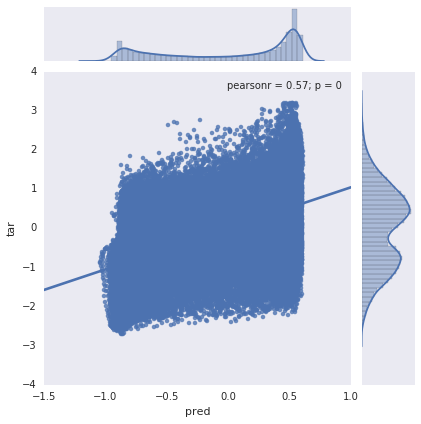

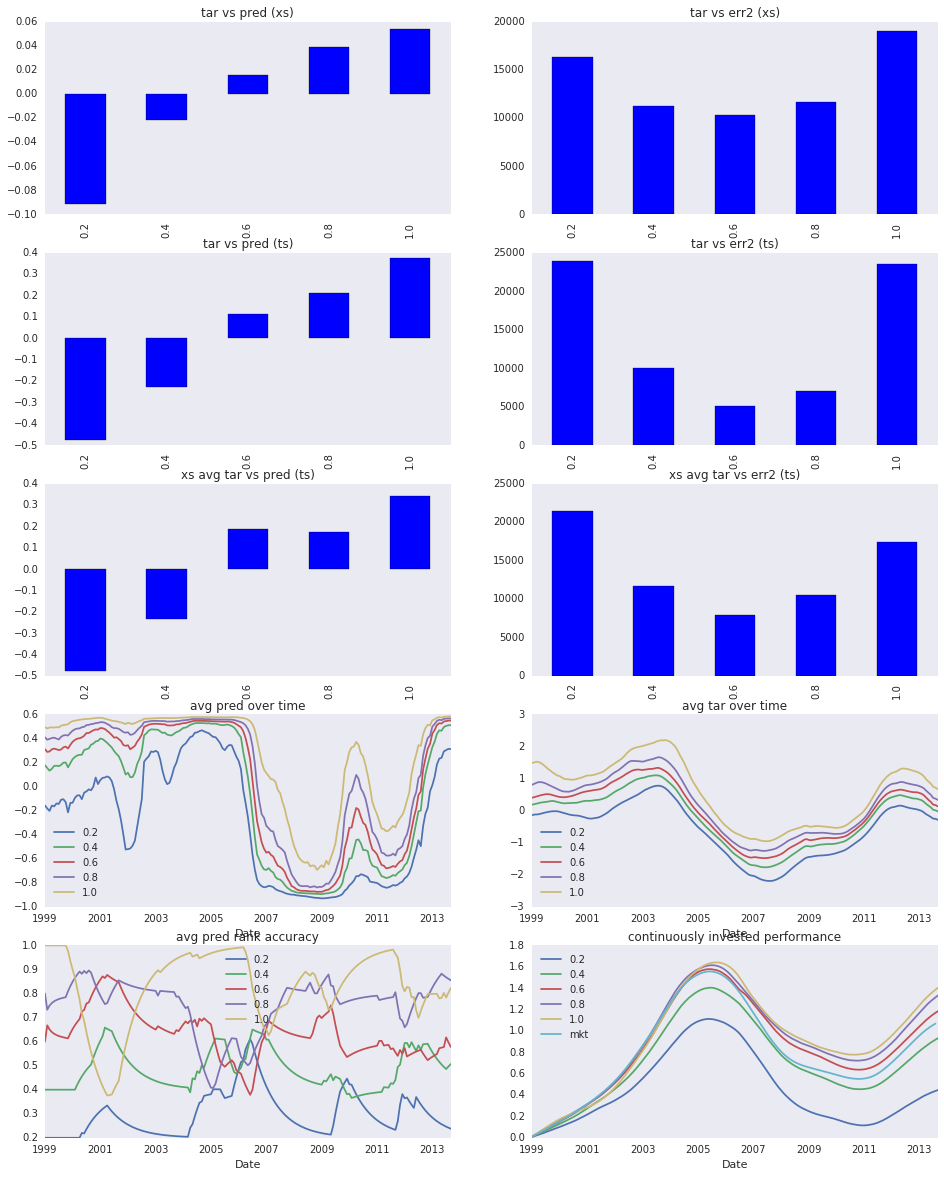

In [53]:
clf = GridSearchCV(lm.Ridge(), param_grid={'alpha': [1., 10., 100, 1000, 10000, 50000, 10000000]}, cv=5, iid=False)
df_ts = ut.ts_score(df, PANEL_SCORE)
clf, df_res, score, pred = composite.build_model(clf, df_ts)
print('int: {0:03f}\tcoef: {1}'.format(clf.best_estimator_.intercept_, clf.best_estimator_.coef_)) 

In [54]:
pred.reset_index().to_csv('data/processed/pred.csv', index=False)

show prediction in map

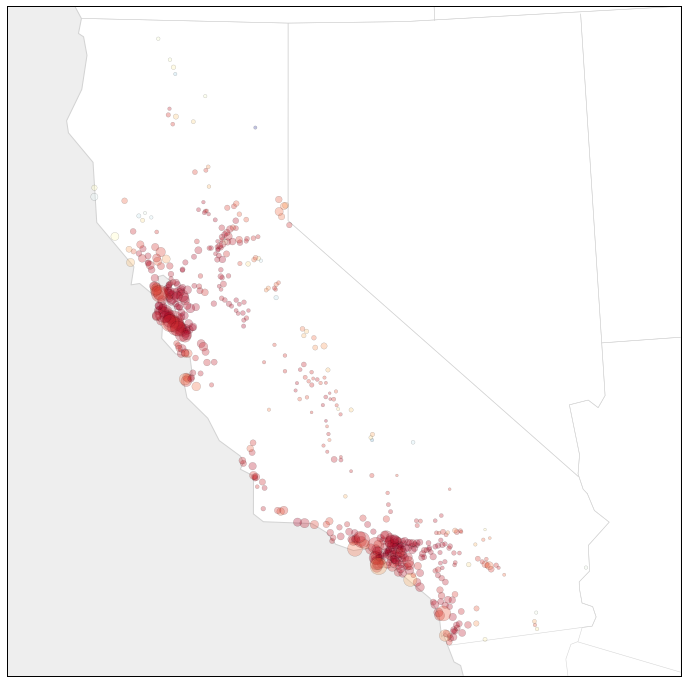

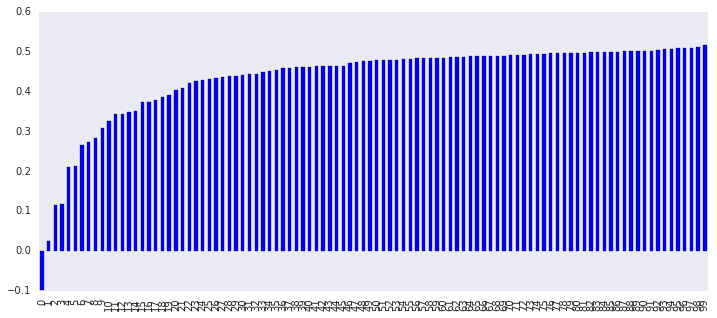

In [44]:
map_pred = maps.load_pred_for_map()
cm = plt.cm.get_cmap('RdYlBu')
m = maps.draw_CA()
row = map_pred.loc[map_pred.index.levels[0][-1]]
style = dict(marker='o', alpha=0.3, zorder=2, latlon=True, label='cities', cmap=cm)
m.scatter(row.lon.values, row.lat.values, s=row.px.map(lambda x: x * .0001).values, c=row.pred.values * -1., **style)
plt.figure()
pd.Series(row.sample(n=100).pred.sort_values().values).plot(kind='bar', figsize=(12,5))

lasso model

[mean: -2.40597, std: 1.19904, params: {'alpha': 0.0001},
 mean: -2.34243, std: 1.17986, params: {'alpha': 0.001},
 mean: -2.25342, std: 1.11251, params: {'alpha': 0.01},
 mean: -2.42840, std: 1.07287, params: {'alpha': 0.1}]


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


r2: 0.324902	xs corr: 0.230208


sharpe ratios:
0.2    1.166054
0.4    1.746932
0.6    1.963387
0.8    2.092692
1.0    2.146345
mkt    1.837238
dtype: float64
int: 0.000000	coef: [-0.01682122 -0.15080751  0.41464113]


/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


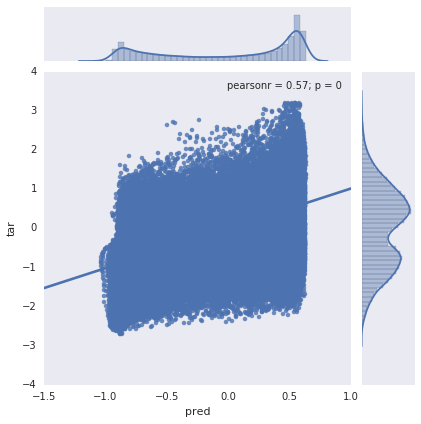

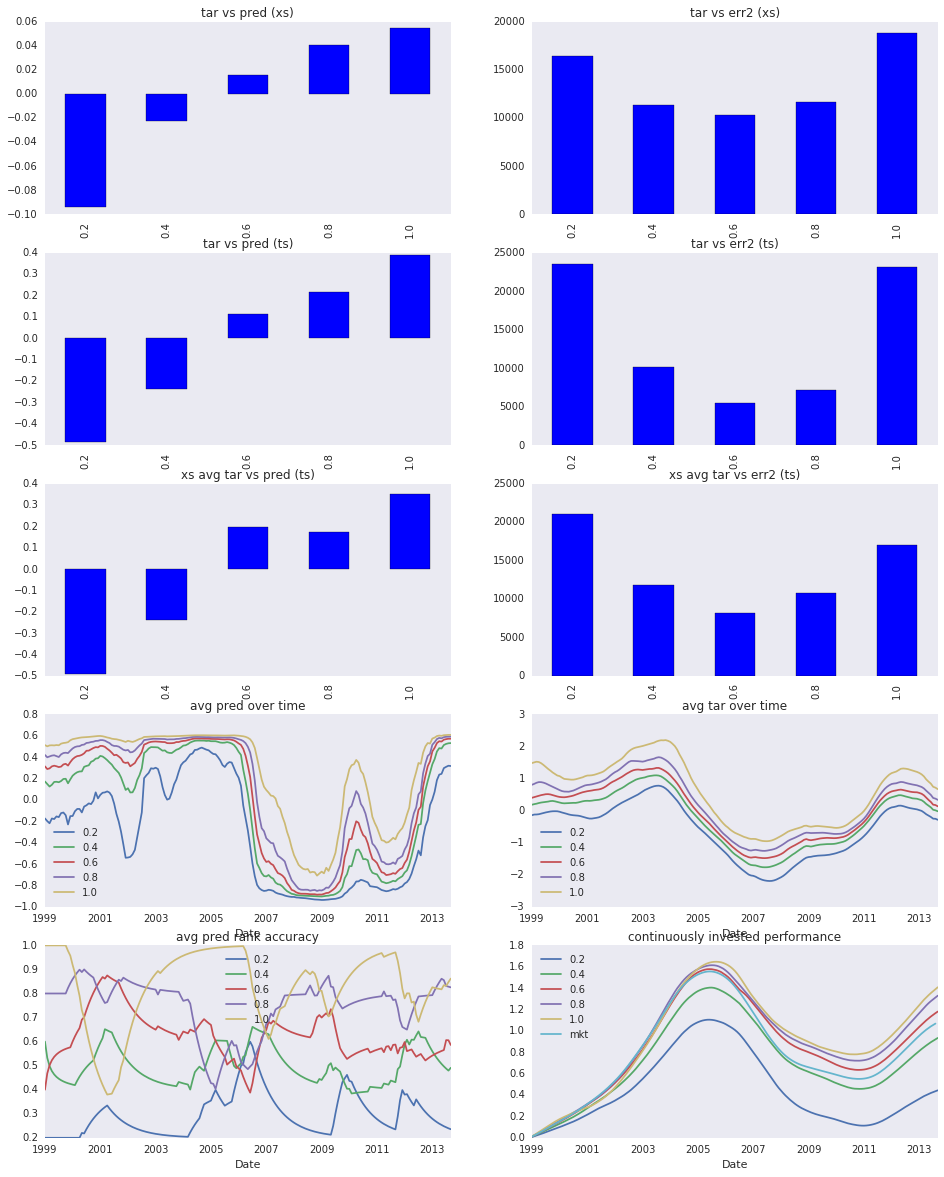

In [55]:
clf = GridSearchCV(lm.Lasso(), param_grid={'alpha': [.0001, .001, .01, .1]}, cv=5, iid=False)
df_ts = ut.ts_score(df, PANEL_SCORE)
clf, df_res, score, pred = composite.build_model(clf, df_ts, PANEL_SCORE)
print('int: {0:03f}\tcoef: {1}'.format(clf.best_estimator_.intercept_, clf.best_estimator_.coef_)) 

[mean: -2.25280, std: 1.13481, params: {'max_depth': 2, 'max_features': None},
 mean: -2.35864, std: 1.01743, params: {'max_depth': 2, 'max_features': 1},
 mean: -2.22521, std: 1.12309, params: {'max_depth': 2, 'max_features': 2},
 mean: -2.29866, std: 1.22966, params: {'max_depth': 3, 'max_features': None},
 mean: -2.23158, std: 1.13784, params: {'max_depth': 3, 'max_features': 1},
 mean: -2.26118, std: 1.19631, params: {'max_depth': 3, 'max_features': 2},
 mean: -2.36939, std: 1.25137, params: {'max_depth': 5, 'max_features': None},
 mean: -2.26675, std: 1.23941, params: {'max_depth': 5, 'max_features': 1},
 mean: -2.34190, std: 1.24627, params: {'max_depth': 5, 'max_features': 2},
 mean: -2.41719, std: 1.26831, params: {'max_depth': 7, 'max_features': None},
 mean: -2.33994, std: 1.25655, params: {'max_depth': 7, 'max_features': 1},
 mean: -2.39511, std: 1.27045, params: {'max_depth': 7, 'max_features': 2}]


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
      

/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


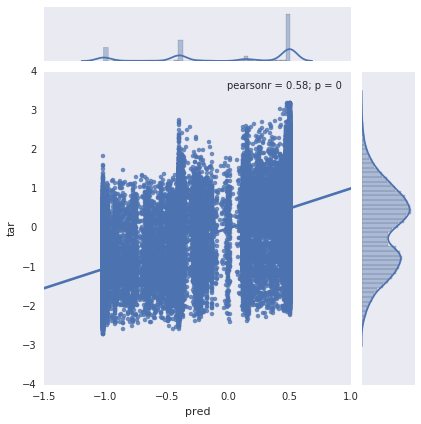

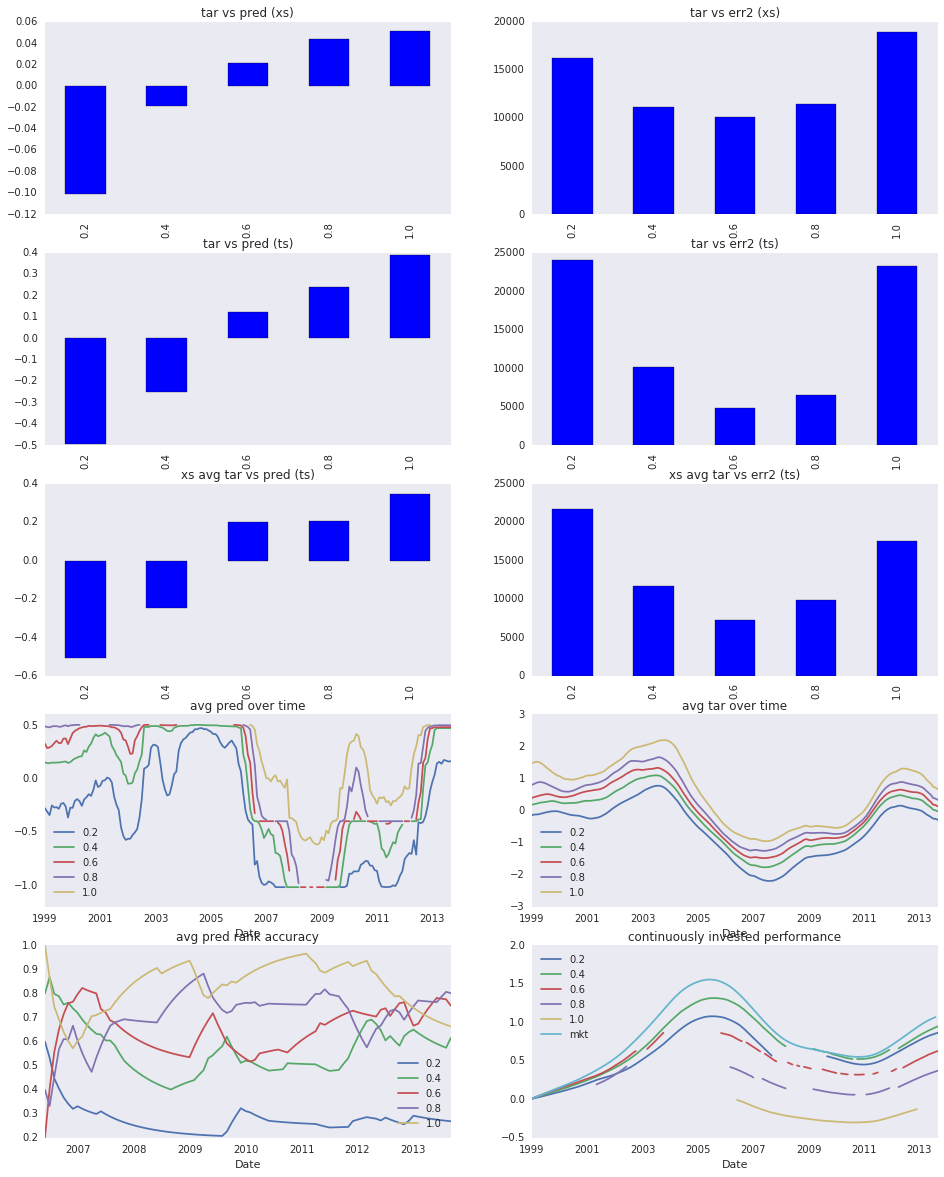

In [58]:
clf = GridSearchCV(RandomForestRegressor(n_estimators=100), 
                   param_grid={'max_depth': [2,3,5,7], 'max_features': [None, 1, 2,]}, 
                   cv=5, n_jobs=1, iid=False)
clf, df_res, score, pred = composite.build_model(clf, df, PANEL_SCORE)

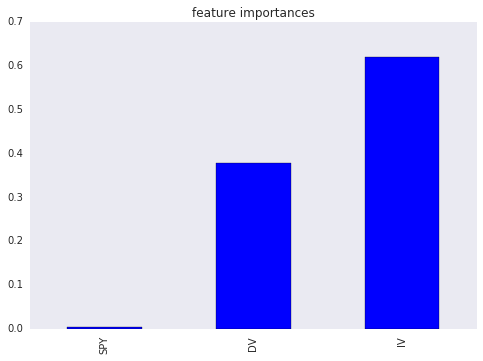

In [59]:
(pd.Series(clf.best_estimator_.feature_importances_, index=[c for c in df.columns if c != 'tar'])
 .plot(kind='bar', title='feature importances'))

In [ ]:
# clf = GridSearchCV(GradientBoostingRegressor(), param_grid={'n_estimators': [50, 200],
#                                                             'max_depth': [1,3,5], 
#                                                             'max_features': [None, 1, 2]}, 
#                    cv=5, n_jobs=2, idd=False)
# clf, df_res, score, pred = composite.build_model(clf, df, PANEL_SCORE)

In [ ]:
# (pd.Series(clf.best_estimator_.feature_importances_, index=[c for c in df.columns if c != 'tar'])
#  .plot(kind='bar', title='feature importances'))